NOM ET PRENOM:
- KAISS Rayann
- ZAROUTA Neila
- EL AISSI Abdelaziz

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Importation du dataset Kaggle

In [8]:
# Installer d'abord le package kaggle
! pip install -q kaggle
# Création un dossier kaggle
! mkdir ~/.kaggle/
# Copier kaggle.json dans le dossier kaggle
! cp 'kaggle.json' ~/.kaggle/
# donner les droits a kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c g-research-crypto-forecasting
! unzip train.csv.zip

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
__init__.py: Skipping, found more recently modified local copy (use --force to force download)
competition.cpython-37m-x86_64-linux-gnu.so: Skipping, found more recently modified local copy (use --force to force download)
example_test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
supplemental_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
example_sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
asset_details.csv: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Préprocessing

Nous allons spliter nos donnée pour l'entrainement et le test. Comme nous somme face à un problème de série temporelles, nous avons décidé de prendre les deux premières années en temps que données d'entrainement le dernière année (compsé de seulement 8 mois) pour les données de test.

In [9]:
def read_csv_tarin(file_name):
    df = pd.read_csv(file_name)
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df[df['datetime'] < '2020-01-01 00:00:00']
    return df

def read_csv_test(file_name):
    df = pd.read_csv(file_name)
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df[df['datetime'] >= '2020-01-01 00:00:00']
    df = df[df['datetime'] < '2020-09-01 00:00:00']
    return df

In [10]:
df_asset_details = pd.read_csv('asset_details.csv') # Contient les informations relative à chaque marché

df_train = read_csv_tarin('train.csv')

df_test = read_csv_test('train.csv')

In [ ]:
df_train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,datetime
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218,2018-01-01 00:01:00
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399,2018-01-01 00:01:00
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643,2018-01-01 00:01:00
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922,2018-01-01 00:01:00
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264,2018-01-01 00:01:00


In [ ]:
df_test.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,datetime
12007908,1577836860,3,89.0,0.032750,0.03278,0.03272,0.032749,30996.056074,0.032747,0.001130,2020-01-01 00:01:00
12007909,1577836860,2,18.0,204.223333,204.52000,203.49000,204.130000,22.129591,204.193203,0.000110,2020-01-01 00:01:00
12007910,1577836860,0,15.0,13.710000,13.71490,13.70570,13.713600,518.490000,13.707626,-0.000088,2020-01-01 00:01:00
12007911,1577836860,1,473.0,7178.211429,7200.00000,7151.92000,7176.200000,43.964876,7177.022443,-0.000145,2020-01-01 00:01:00
12007912,1577836860,5,36.0,2.581060,2.58530,2.56700,2.581000,1712.897391,2.580874,0.000155,2020-01-01 00:01:00


In [ ]:
df_asset_details.head()

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic


#### Bitcoin

Dans le cadre de ce projet nous allons nous concentrer sur le Bitcoin. Il s'agit du marché le plus liquide (c'est à dire que c'est le marché le plus échangé chaque jour).

(dans un marché liquide les prix sont très arbitrés et donc la valeur constaté reflète au mieux le vrai prix que doit valoir l'actif en question)

In [56]:
df_bitcoin = df_train.loc[(df_train['Asset_ID'] == 1)]
df_bitcoin_test = df_test.loc[(df_test['Asset_ID'] == 1)]

In [57]:
print(df_bitcoin.shape)
df_bitcoin.head()

(1050557, 11)


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,datetime
2,1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643,2018-01-01 00:01:00
10,1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037,2018-01-01 00:02:00
18,1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309,2018-01-01 00:03:00
26,1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999,2018-01-01 00:04:00
34,1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079,2018-01-01 00:05:00


#### Sélection de variables

Notre dataset est composé de plusieurs variables. Open High Low et Close sont toutes corrélés étant donnée qu'il s'agit, pour chaque minute, de quasiment la même variables. Par exmple High représente simplement le prix le plus haut qui a était atteint durant la minute.

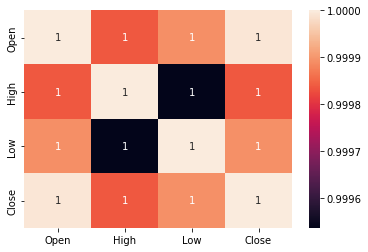

In [ ]:
sns.heatmap(df_bitcoin[['Open', 'High', 'Low', 'Close']].corr(), annot=True)
plt.show()

Nous allons donc juste choisir le prix de cloture

In [58]:
# pour dataset training
df_bitcoin = df_bitcoin[['Close']]
df_bitcoin = df_bitcoin.values
df_bitcoin = df_bitcoin.astype('float32')

# pour dataset test
df_bitcoin_test = df_bitcoin_test[['Close']]
df_bitcoin_test = df_bitcoin_test.values
df_bitcoin_test = df_bitcoin_test.astype('float32')

In [82]:
print("Shape des données d'entraianement : ", df_bitcoin.shape)

Shape des données d'entraianement :  (1050557, 1)


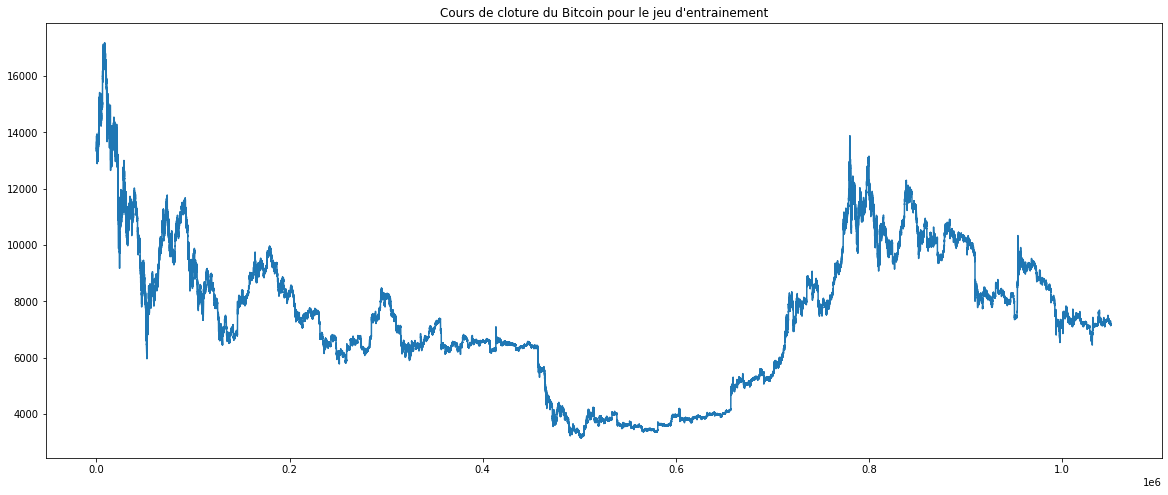

In [63]:
plt.figure(figsize=(20,8))
plt.plot(df_bitcoin)
plt.title("Cours de cloture du Bitcoin pour le jeu d'entrainement")
plt.show()

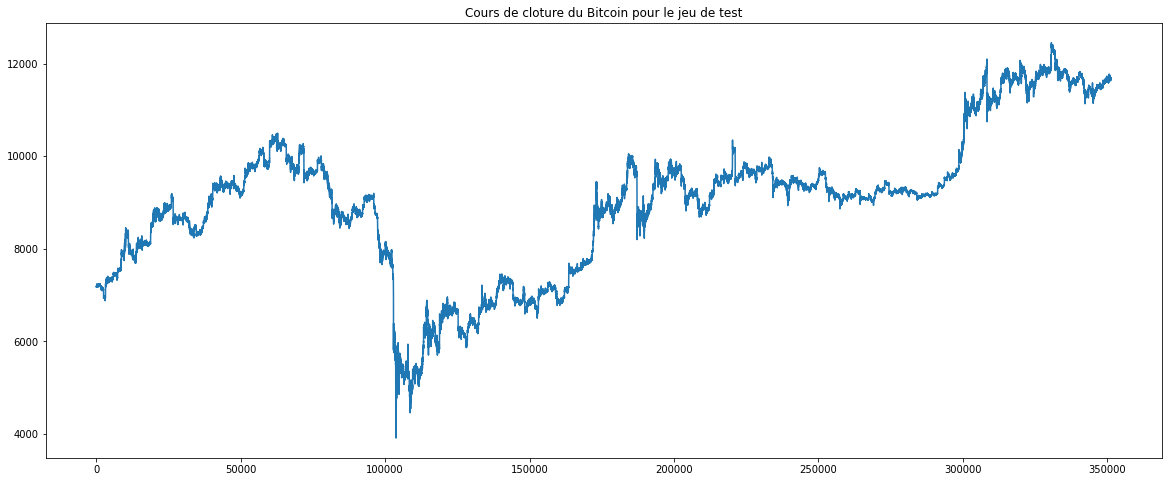

In [64]:
plt.figure(figsize=(20,8))
plt.plot(df_bitcoin_test)
plt.title("Cours de cloture du Bitcoin pour le jeu de test")
plt.show()

#### Normalisation

Nous pouvons travailler ici avec des données normalisé. Mais attention ! Dans la pratique, les futures prix du bitcoin dépasseront certainement le prix maximum que l'on a ici.

In [60]:
scaler = MinMaxScaler(feature_range=(0, 1))

df_bitcoin_norm = scaler.fit_transform(df_bitcoin)
df_bitcoin_test_norm = scaler.fit_transform(df_bitcoin_test)

#### Format pour l'entrainement et labelisation

In [11]:
def create_dataset(dataset, look_back): # Cette fonction met un jeu de donnée au bon format pour l'entrainement de modèle LSTM
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  dataX, dataY = np.array(dataX), np.array(dataY)
  return dataX.reshape(dataX.shape[0], 1, dataX.shape[1]), dataY

In [61]:
X_train, y_train = create_dataset(df_bitcoin_norm, 100)
X_test, y_test = create_dataset(df_bitcoin_test_norm, 100)

print("X_train.shape: ", X_train.shape, "   y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape, "   y_test.shape: ", y_test.shape)

X_train.shape:  (1050457, 1, 100)    y_train.shape:  (1050457,)
X_test.shape:  (351252, 1, 100)    y_test.shape:  (351252,)


# Premier modèle

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, CuDNNLSTM
from keras.layers import Dropout


def create_model():

  model = Sequential()

  model.add(CuDNNLSTM(units = 100, return_sequences = True, input_shape = (1, X_train.shape[2])))
  model.add(Dropout(0.2))

  model.add(CuDNNLSTM(units = 100, return_sequences = True))
  model.add(Dropout(0.2))

  model.add(CuDNNLSTM(units = 100, return_sequences = True))
  model.add(Dropout(0.2))

  model.add(CuDNNLSTM(units = 100))
  model.add(Dropout(0.2))

  model.add(Dense(units = 1))

  model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse', 'mae', 'mape'])

  model.summary()

  return model

model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm (CuDNNLSTM)      (None, 1, 100)            80800     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 1, 100)            80800     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 1, 100)            80800     
                                                                 
 dropout_2 (Dropout)         (None, 1, 100)            0         
                                                                 
 cu_dnnlstm_3 (CuDNNLSTM)    (None, 100)               8

#### Entrainement et prédictions

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=128)

Epoch 1/5
8207/8207 [==============================] - 110s 12ms/step - loss: 6.3609e-04 - mse: 6.3609e-04 - mae: 0.0155 - mape: 81.6671
Epoch 2/5
8207/8207 [==============================] - 95s 12ms/step - loss: 2.6575e-04 - mse: 2.6575e-04 - mae: 0.0117 - mape: 27.5477
Epoch 3/5
8207/8207 [==============================] - 95s 12ms/step - loss: 2.2718e-04 - mse: 2.2718e-04 - mae: 0.0109 - mape: 22.1322
Epoch 4/5
8207/8207 [==============================] - 95s 12ms/step - loss: 2.0592e-04 - mse: 2.0592e-04 - mae: 0.0104 - mape: 31.9653
Epoch 5/5
8207/8207 [==============================] - 95s 12ms/step - loss: 1.9539e-04 - mse: 1.9539e-04 - mae: 0.0101 - mape: 34.4929


In [12]:
def plot_history(history):
  plt.figure(figsize=(10, 5))
  plt.plot(history.epoch, history.history['loss'], label='Training Loss')
  # plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
  plt.title("Evolution de la loss en fonction du nombre d'epoch")
  plt.xlabel('Epoch', fontsize=12)
  plt.ylabel('Loss', fontsize=12)
  plt.legend()
  plt.show()

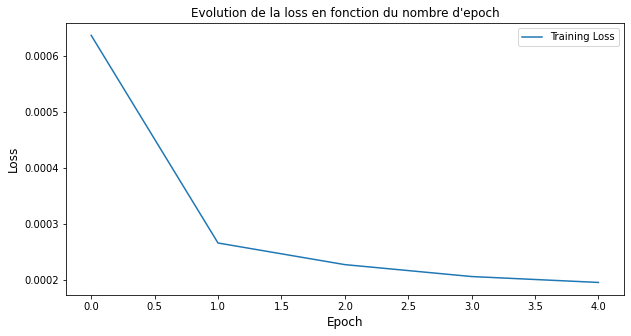

In [ ]:
plot_history(history)

In [ ]:
y_predected = model.predict(X_test)

In [ ]:
def plot_predictions(real_price, predicted_price, title):
  plt.figure(figsize=(20,6))
  plt.plot(real_price, color = 'green', label = 'Prix réel')
  plt.plot(predicted_price, color = 'red', label = 'Prix prédit')
  plt.title(title)
  plt.xlabel('Temps')
  plt.ylabel('Prix du Bitcoin')
  plt.legend()
  plt.show()

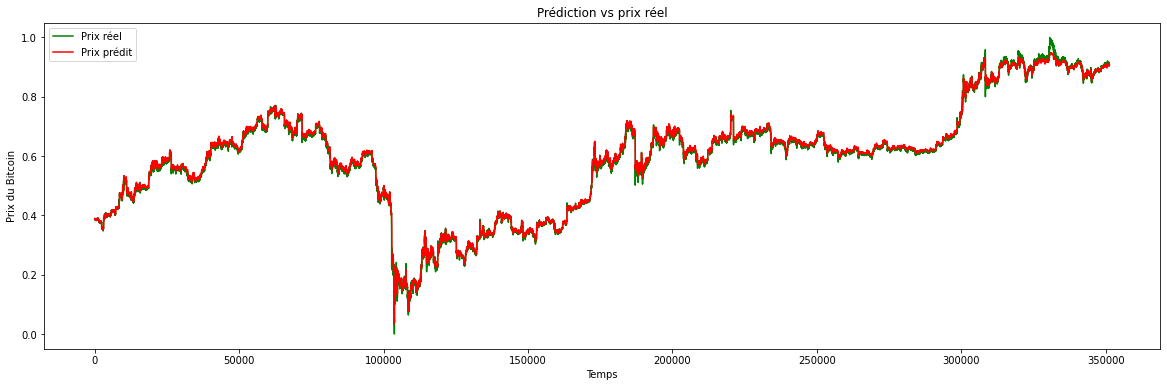

In [ ]:
plot_predictions(y_test, y_predected, "Prédiction vs prix réel")

On remarque un décallage systématique entre les prédiction et le vrai prix du Bitcoin. Cela est dû à un phénomène simple. Le réseaux tente d'apprendre également la tendance des cours ce qui est très compliqué. Pour pallier à cela on va uniquement considérer le "rendement" (pas en pourcentage mais juste en brut)  et non le prix. Le rendement sera donc simplement P(t)-P(t-1). Ainsi, l'algorithme peut maintenant se concentrer uniquement sur la variation du bitcoin vis à vis du prix à t-1.

# Modèle à partir des rendements

Nous allons donc reprendre les données non labélisé faire les traitements comme précédemment puis transformer la liste de prix en liste de return. Ensuite nous réutiliserons 'create_dataset' pour mettre au bon format et labéliser.

In [13]:
# Pré-traitement

df = df_train.loc[(df_train['Asset_ID'] == 1)]
df_Test = df_test.loc[(df_test['Asset_ID'] == 1)]
df = df[['Close']]
df = df.values
df = df.astype('float32')

df_Test = df_Test[['Close']]
df_Test = df_Test.values
df_Test = df_Test.astype('float32')

df_bitcoin_dataframe = pd.DataFrame(df)
df_bitcoin_dataframe_test = pd.DataFrame(df_Test)

# Obtention des rendements

df_bitcoin_return = df_bitcoin_dataframe-df_bitcoin_dataframe.shift(1)
df_bitcoin_return = df_bitcoin_return.dropna()
df_bitcoin_return = np.array(df_bitcoin_return)

df_bitcoin_return_test = df_bitcoin_dataframe_test-df_bitcoin_dataframe_test.shift(1)
df_bitcoin_return_test = np.array(df_bitcoin_return_test.dropna())

In [14]:
X_train_return, y_train_return = create_dataset(df_bitcoin_return, 100)

In [15]:
X_test_return, y_test_return = create_dataset(df_bitcoin_return_test, 100)

#### Nouvelle architecture pour nos rendements

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, CuDNNLSTM
from keras.layers import Dropout
from keras.layers import BatchNormalization, Flatten

In [27]:
def create_model_return():
  model_return = Sequential()
  model_return.add(LSTM(100, return_sequences = True, input_shape = (1, X_train_return.shape[2]), activation = 'relu'))
  model_return.add(Dropout(0.25))
  #model_return.add(LSTM(100, return_sequences = True, activation = 'relu'))
  #model_return.add(Dropout(0.25))
  model_return.add(Flatten()) 
  model_return.add(Dense(units = 1))

  model_return.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse', 'mae', 'mape'])

  model_return.summary()

  return model_return

model_return = create_model_return()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            80400     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 80,501
Trainable params: 80,501
Non-trainable params: 0
_________________________________________________________________


#### Entrainement

In [ ]:
history_return = model_return.fit(X_train_return, y_train_return, epochs=10, batch_size=128)

Epoch 1/10
8207/8207 [==============================] - 87s 10ms/step - loss: 94.8294 - mse: 94.8294 - mae: 5.2713 - mape: 85796.1094
Epoch 2/10
8207/8207 [==============================] - 88s 11ms/step - loss: 94.2129 - mse: 94.2129 - mae: 5.2530 - mape: 85746.0312
Epoch 3/10
8207/8207 [==============================] - 85s 10ms/step - loss: 93.9668 - mse: 93.9668 - mae: 5.2567 - mape: 92253.4766
Epoch 4/10
8207/8207 [==============================] - 85s 10ms/step - loss: 93.6064 - mse: 93.6064 - mae: 5.2602 - mape: 92087.1953
Epoch 5/10
8207/8207 [==============================] - 87s 11ms/step - loss: 93.1384 - mse: 93.1384 - mae: 5.2629 - mape: 111874.0781
Epoch 6/10
8207/8207 [==============================] - 86s 10ms/step - loss: 92.6016 - mse: 92.6016 - mae: 5.2634 - mape: 132119.7031
Epoch 7/10
8207/8207 [==============================] - 87s 11ms/step - loss: 92.0443 - mse: 92.0443 - mae: 5.2623 - mape: 165236.9688
Epoch 8/10
8207/8207 [==============================] - 87s

In [ ]:
history_return = model_return.fit(X_train_return, y_train_return, epochs=5, batch_size=128)

Epoch 1/5
8207/8207 [==============================] - 89s 11ms/step - loss: 90.1246 - mse: 90.1246 - mae: 5.2506 - mape: 192198.0938
Epoch 2/5
8207/8207 [==============================] - 102s 12ms/step - loss: 89.6913 - mse: 89.6913 - mae: 5.2472 - mape: 204208.6719
Epoch 3/5
8207/8207 [==============================] - 91s 11ms/step - loss: 89.3390 - mse: 89.3390 - mae: 5.2445 - mape: 198373.8125
Epoch 4/5
8207/8207 [==============================] - 88s 11ms/step - loss: 88.9261 - mse: 88.9261 - mae: 5.2390 - mape: 215342.7500
Epoch 5/5
8207/8207 [==============================] - 88s 11ms/step - loss: 88.5355 - mse: 88.5355 - mae: 5.2364 - mape: 194713.6875


#### Sauvegarde

In [ ]:
model_return.save('/content/my_model.h5')

In [16]:
from keras.models import load_model
model_return = load_model("/content/my_model.h5")

In [17]:
y_predected = model_return.predict(np.asarray(X_test_return).astype(np.float32)) # Prédiction sur 200 000 valeurs au lieu de 350 000 (problème de RAM)

In [ ]:
with open('prédictions.txt', 'w') as f:
    for item in y_predected:
        f.write("%s\n" % item)

#### Rendements prédits vs rendements réels

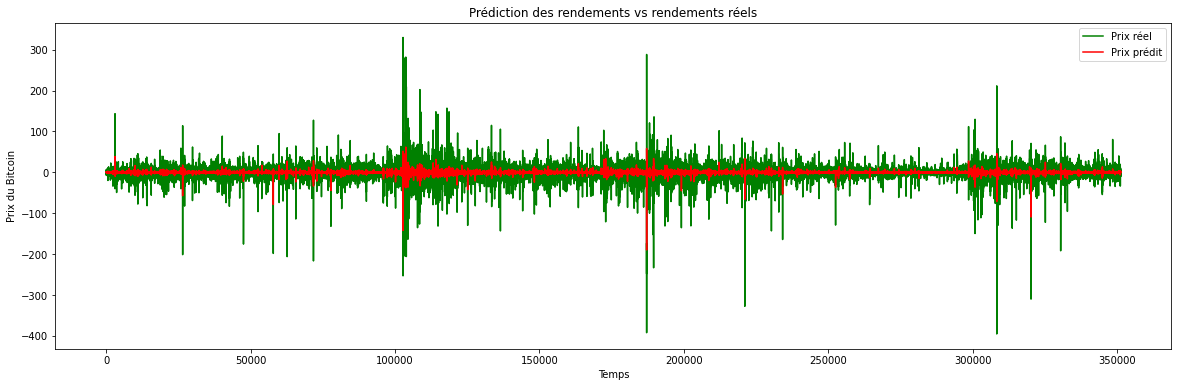

In [ ]:
plot_predictions(y_test_return, y_predected, "Prédiction des rendements vs rendements réels")

On remarque que la volatilitée des prédictions est faible comparé à celle des rendements réel. En faite c'est normale. Avec la métrique que nous avons utilisé, le modèle ne va pas chercher à prendre de risque sur ses prédictions. Pour l'instant nous allons garder cette métrique car celle-ci reste intéressante pour la stratégie que nous allons utiliser.

#### Prix prédit vs prix réel (à compléter)

Pour cela nous avons besoin d'ajouter les rendements aux prix à t-1

In [87]:
X_test, y_test = create_dataset(df_bitcoin_test, 100)

In [ ]:
y_predected = y_predected.reshape(y_predected.shape[0],)

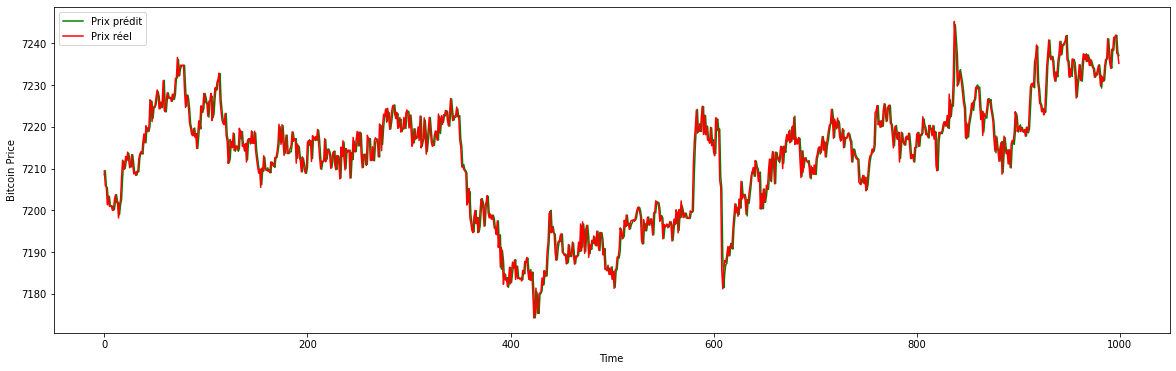

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(y_test[0:1000]+y_predected[0:1000], color = 'green', label = 'Prix prédit') #affiche seulement 1000 valeurs
plt.plot(y_test[0:1000]+y_test_return[0:1000], color = 'red', label = 'Prix réel')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

Maintenant nos prix prédit "collent" au marché.

# Stratégie de trading

Notre modèle prédit le rendemment de la prochaine minute à partir des 100 dernières. Il est évident que quand le modèle prédit que le rendemment sera positif mais très faible alors notre algo peut se tromper et en réalité le rendemment sera légèrement négatif. Egalement le modèle peut prédire que le cours ne va pas bouger alors que celui-ci décalle fortement à la hausse ou à la baisse. Notre stratégie consistera donc à:
- Garder une position seuelement 1 minute
- acheter quand le modèle prédit un rendement anormalement grand
- shorter (vendre à découvert) quand le marché prédit un rendement anormalement faible

In [ ]:
# Récupération des prédiction à partir de notre fichier

#y_predected = np.array([])
#with open('prédictions.txt', 'r') as f:
#  for i in range(0, 300000):
#    line = f.readline()[1:-2]
#    if(i>=0):
#      y_predected = np.append(y_predected, float(line))

Nous allons utiliser une petite partie des données de tests (10 000 ou 20 000) pour savoir ce qu'est une prédiction anormalement grande ou anormalement faible. Nous cherchons à prédire environ 5% du temps seulement.

In [18]:
def seuil_(pred, portion):
  small = pred[0:20000]
  seuil = np.median(small)
  while ((small>seuil).sum()>int(portion*small.shape[0])): 
    seuil+=0.01
  Seuil_hausse = seuil
  seuil=np.median(small)
  while (small<seuil).sum()>int(portion*small.shape[0]):
    seuil-=0.01
  Seuil_baisse = seuil

  return Seuil_hausse, Seuil_baisse


In [19]:
Seuil_hausse, Seuil_baisse = seuil_(y_predected, 0.05)

#### Stratégie d'achat

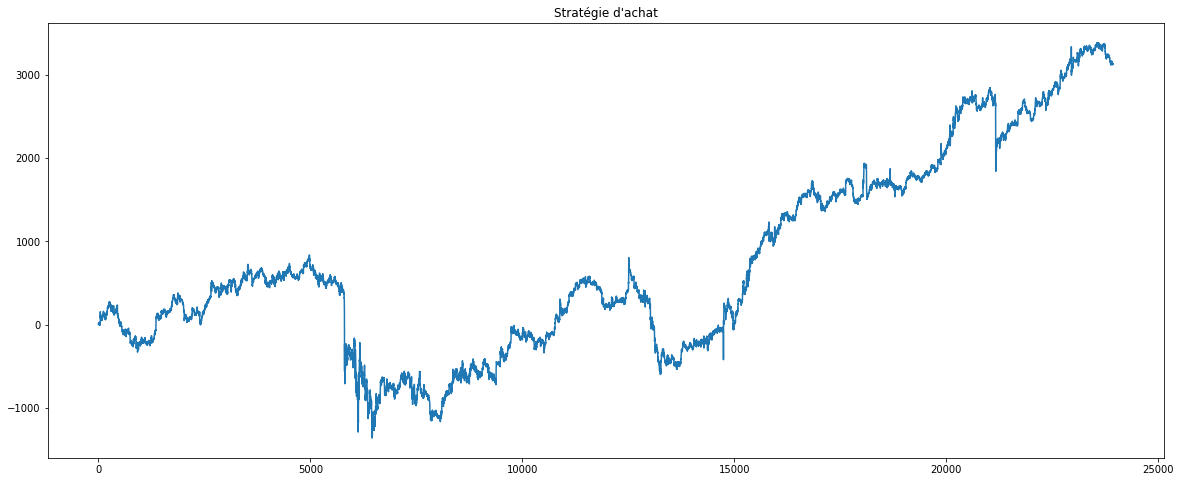

In [21]:
Compte_achat=[0]

def achat(pred, compte, seuil):
  for i in range(len(pred)-1):
    if(pred[i]>seuil):
      compte+=[compte[-1]+y_test_return[i]]
  plt.figure(figsize=(20,8))
  plt.plot(compte)
  plt.title("Stratégie d'achat")
  plt.show()

  return compte

Compte_achat = achat(y_predected, Compte_achat, Seuil_hausse)

#### Stratégie de vente

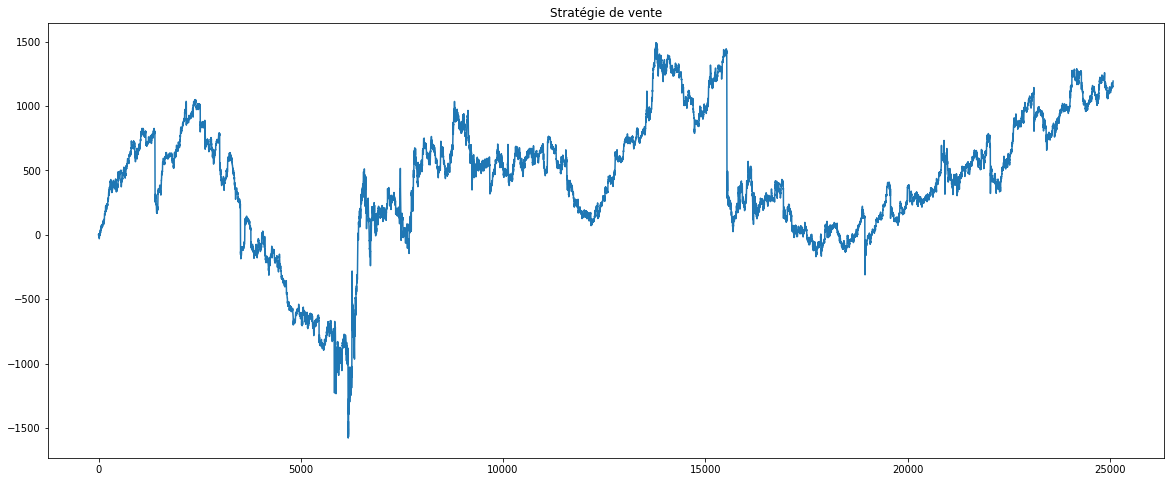

In [22]:
Compte_vente=[0]

def vente(pred, compte, seuil):
  for i in range(len(pred)-1):
    if(pred[i]<seuil):
      compte+=[compte[-1]+y_test_return[i]]
  plt.figure(figsize=(20,8))
  plt.plot(compte)
  plt.title("Stratégie de vente")
  plt.show()
  return compte

Compte_vente = vente(y_predected, Compte_vente, Seuil_baisse)

#### Comparaison avec un modèle de référence

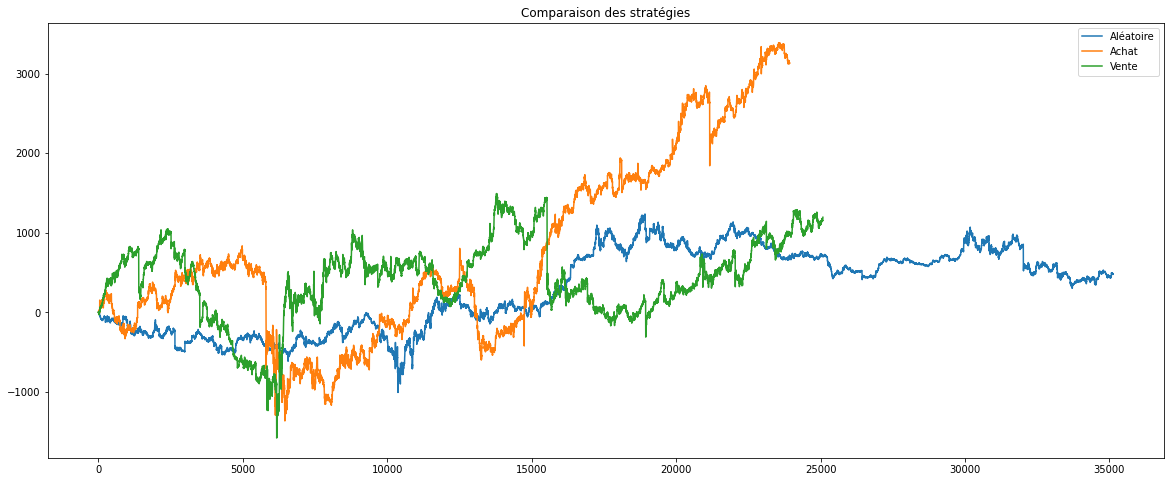

In [23]:
Aléatoire=[0]
for i in range(len(y_predected)-1):
  if(i%10==0):
    Aléatoire+=[Aléatoire[-1]+y_test_return[i]]
plt.figure(figsize=(20,8))
plt.plot(Aléatoire, label='Aléatoire')
plt.plot(Compte_achat, label='Achat')
plt.plot(Compte_vente, label='Vente')
plt.title("Comparaison des stratégies")
plt.legend()
plt.show()

La stratégie aléatoire est nettement moins performante. Notre modèle a donc réussi à apprendre et à prédire les cours du Bitcoin !

# Overfitting et Underfitting

Ré-entrainons un modèle mais cette fois sur une seul epoch

In [28]:
model = create_model_return()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 80,501
Trainable params: 80,501
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(X_train_return, y_train_return, epochs=1, batch_size=128)

8207/8207 [==============================] - 50s 6ms/step - loss: 94.8999 - mse: 94.8999 - mae: 5.2731 - mape: 93756.7891


In [30]:
y_predected_model = model.predict(X_test_return)

In [31]:
Seuil_hausse_model, Seuil_baisse_model = seuil_(y_predected_model, 0.05) # Etablissement des seuil d'achat et de vente

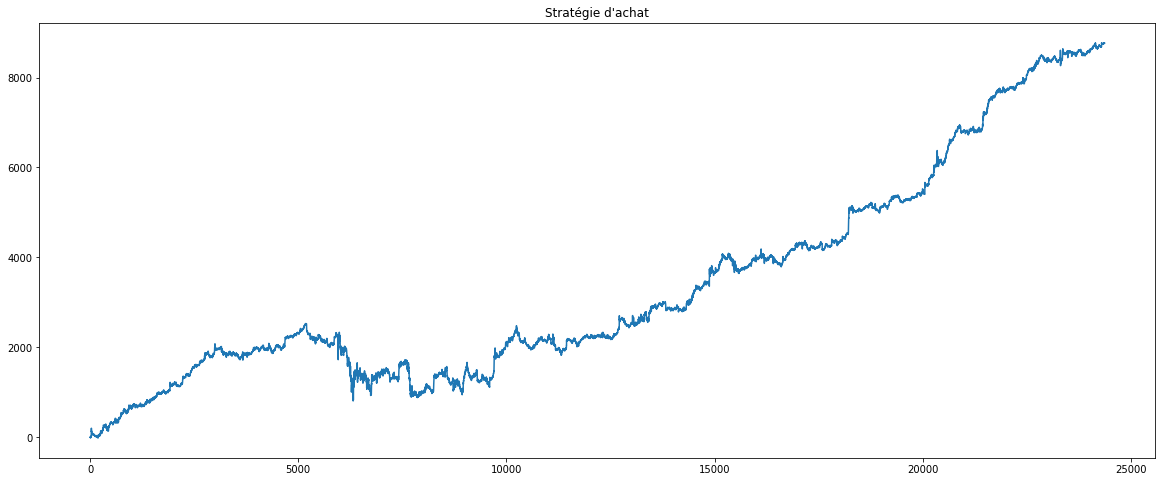

In [32]:
Compte_achat_model=[0]
Compte_achat_model = achat(y_predected_model, Compte_achat_model, Seuil_hausse_model)

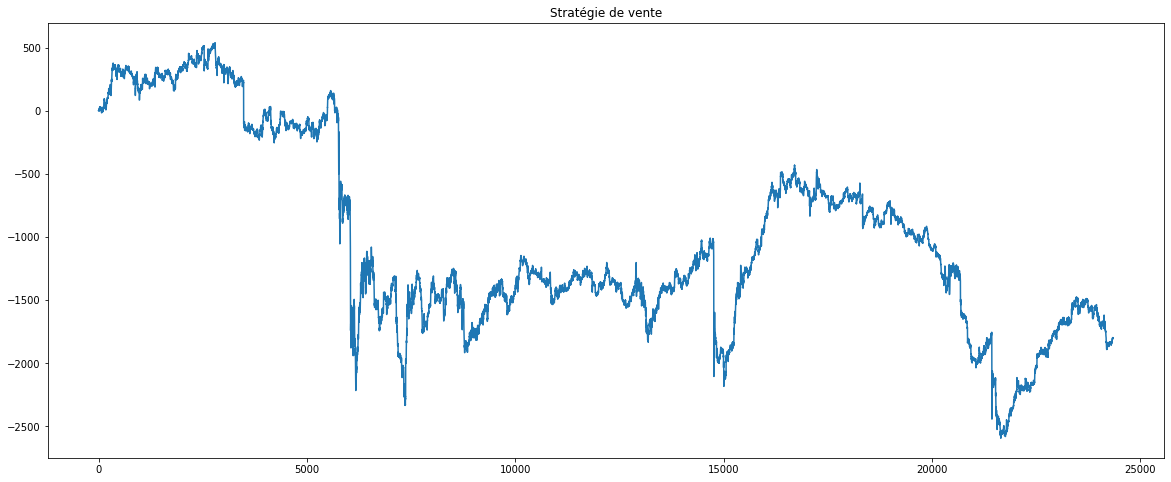

In [33]:
Compte_vente_model=[0]
Compte_vente_model = vente(y_predected_model, Compte_vente_model, Seuil_baisse_model)

On remarque que le modèle moins bien entrainé va avoir du mal à faire de bonnes prédictions de vente. En revanche il est meilleur à l'achat. Voyons ce que cela donne si nous entrainons le modèle sur seulement 100 données d'entrainements

#### Underfitting

In [47]:
model_under = create_model_return()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_4 (Dropout)         (None, 1, 100)            0         
                                                                 
 flatten_4 (Flatten)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 80,501
Trainable params: 80,501
Non-trainable params: 0
_________________________________________________________________


In [48]:
model_under.fit(X_train_return[0:100], y_train_return[0:100], epochs=1, batch_size=128)

1/1 [==============================] - 1s 1s/step - loss: 610.2577 - mse: 610.2577 - mae: 19.1015 - mape: 229.2244


In [49]:
y_predected_model_under = model_under.predict(X_test_return)
Seuil_hausse_model_under, Seuil_baisse_model_under = seuil_(y_predected_model_under, 0.05) # Etablissement des seuil d'achat et de vente

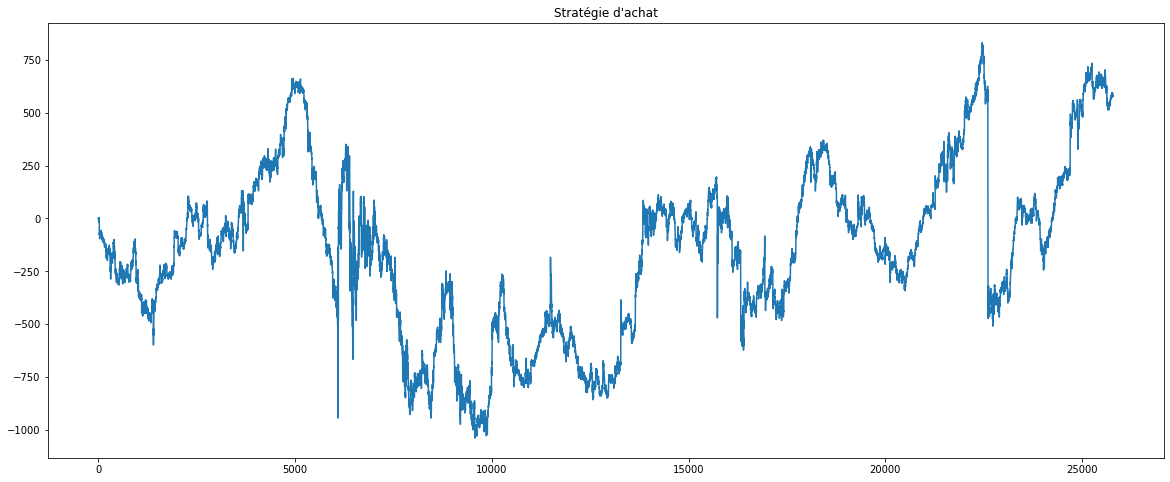

In [50]:
Compte_achat_model_under=[0]
Compte_achat_model_under = achat(y_predected_model_under, Compte_achat_model_under, Seuil_hausse_model_under)

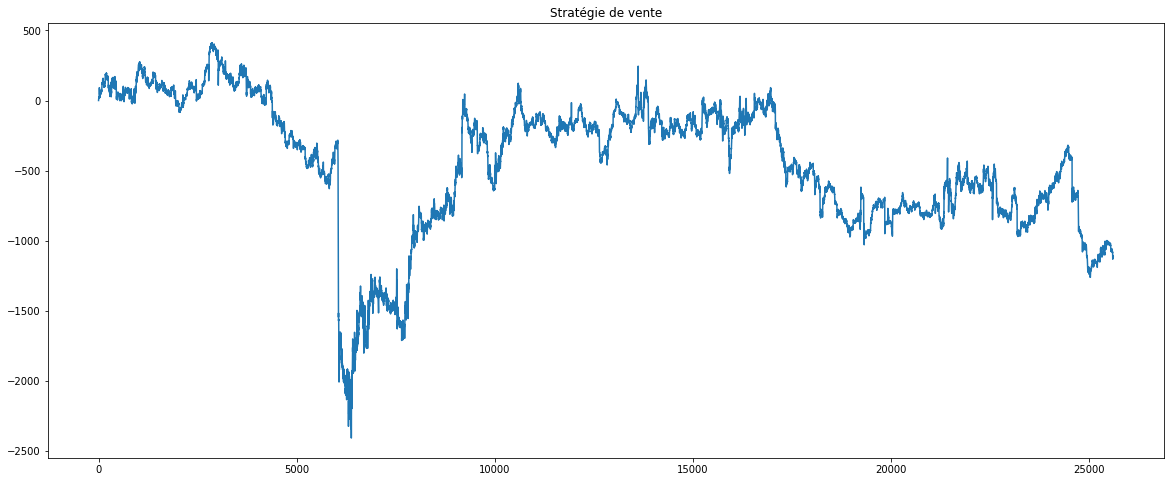

In [51]:
Compte_vente_model_under=[0]
Compte_vente_model_under = vente(y_predected_model_under, Compte_vente_model_under, Seuil_baisse_model_under)

Voilà. On peut maintenant être sûr que nos modèles 'model_return' et 'model' ont appris ! Un modèle entrainé sur seulment 100 données ne peux ni prédire les hausses ni les baisses.

# Conclusions et limitations

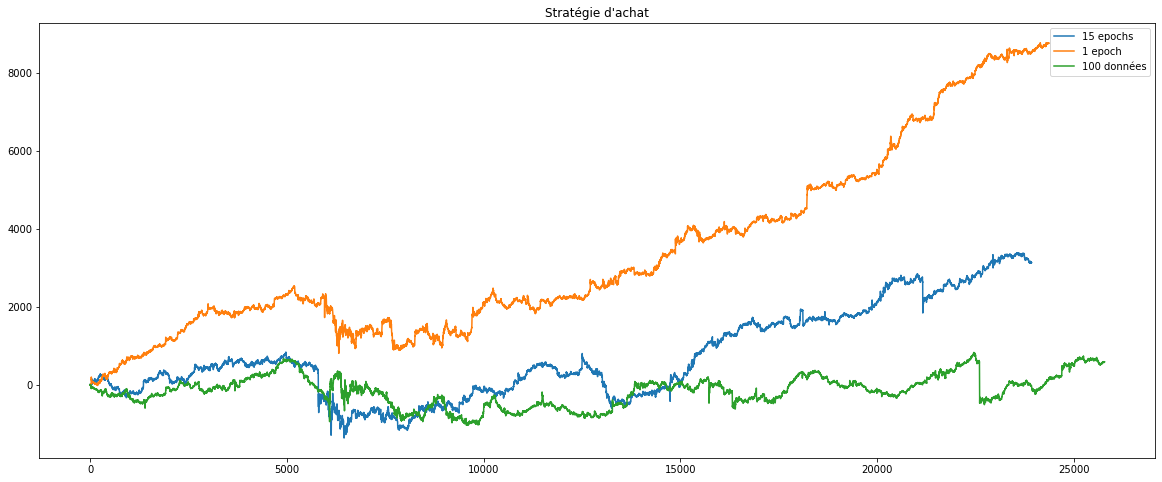

In [54]:
plt.figure(figsize=(20,8))
plt.plot(Compte_achat, label='15 epochs')
plt.plot(Compte_achat_model, label='1 epoch')
plt.plot(Compte_achat_model_under, label='100 données')
plt.title("Stratégie d'achat")
plt.legend()
plt.show()

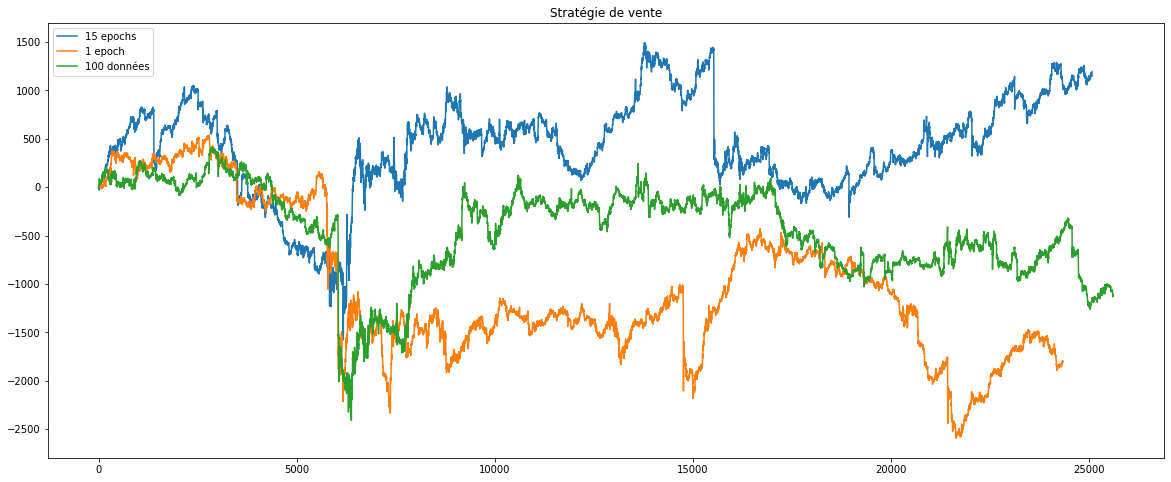

In [55]:
plt.figure(figsize=(20,8))
plt.plot(Compte_vente, label='15 epochs')
plt.plot(Compte_vente_model, label='1 epoch')
plt.plot(Compte_vente_model_under, label='100 données')
plt.title("Stratégie de vente")
plt.legend()
plt.show()

- Quand on entraine l'architecture sur 100 données, la stratégie d'achat et de vente est nulle. Quand on l'entraine sur 1 epoch, le modèle est très bon pour prédire les hausses et mauvais pour prédire les baisses. Et quand on l'entraine sur 15 epochs, le modèle reste bon pour prédire les hausses et deviens neutre pour les baisses. Cela met en exergue que plus le modèle apprend. De plus il va chercher à bien prédire l'ensemble des données. Il est donc meilleur globalement (la stratégie de vente avec 15 epochs est plus gagnante que pour les autres modèle). Mais dans une optique trading nous pouvons par exemple éliminer la stratégie vendeuse et dans ce cas on préferera que le notre modèle sache au mieux prédire les hausses anormales. 
- Idealement nous pouvons mélanger le dataframe construit pour l'entrainement et le test car si notre modèle est aussi bon avec peu d'entrainement pour la stratégie d'achat c'est aussi parceque le marché est très haussier pour le jeu de test. 
- Nous donc par exmple modifier la stratégie de trading en prenant en compte le contexte de marché : quand nous somme haussier nous pourrions faire que des achats et quand nous somme baissier que des ventes.

# Axes d'amélioration

- Dans notre situation nous pouvons mélanger le dataframe au lieu de spliter nos données selon le temps passé (deux premières années vs dernière année)
- Nous pouvons moduler la métrique de performance pour que l'algorithme fasse ce que nous souhaitonss
- Nous pouvons prendre en compte le contexte de marché avec des données horaires ou journalières

#### Performance et volatilité

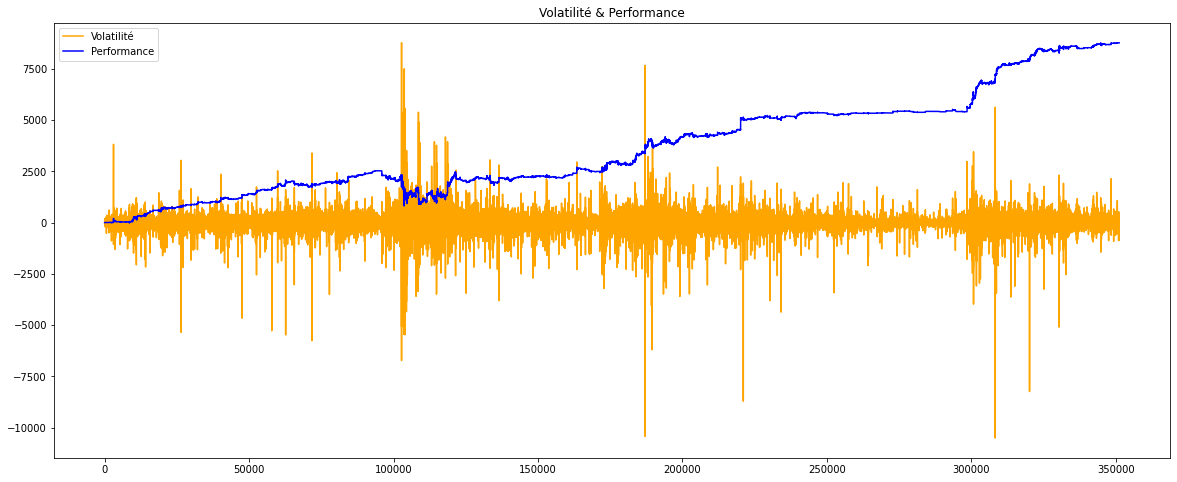

In [78]:
plt.figure(figsize=(20,8))

compte=[0]

Seuil_hausse_model, Seuil_baisse_model = seuil_(y_predected_model, 0.05) # Etablissement des seuil d'achat et de vente

for i in range(len(y_predected_model)-1):
  if(y_predected_model[i]>Seuil_hausse_model):
    compte+=[compte[-1]+y_test_return[i]]
  else:
    compte+=[compte[-1]]

plt.plot(y_test_return*max(compte)/max(y_test_return), label='Volatilité', color='orange')

plt.plot(compte, label='Performance', color='blue')

plt.title("Volatilité & Performance")

plt.legend()

plt.show()



On remarque également que le modèle est mauvais lorsque le marché est volatile. On le voit entre la 100 000ème minute et la 130 000ème minute. Cette période correspond à une sortie de capitaux. Cela s'est produit sur toutes les bourses en mars 2020.
On pourrais par exemple modéliser la volatilité du marché et faire tourner notre algorithme uniquement lorsque la prédiction de la volatilité est raisonnable. Et là pour le coup on cherchera une métrique de performance nous permettant de faire des prédictions plus large sans pénalitées

#### Situation réel

En vérité, si on achète du bitcoin alors des frais nous somme facturés. En se basant sur les frais de Binance (plateforme la plus utilisé pour trader les cryptomonnais) alors il faut considérer 0.01 % du montant. 

In [93]:
print((y_test*0.0001).mean() ,"est le coût moyen pour acheter 1 Bitcoin")

0.89951116 est le coût moyen pour acheter 1 Bitcoin


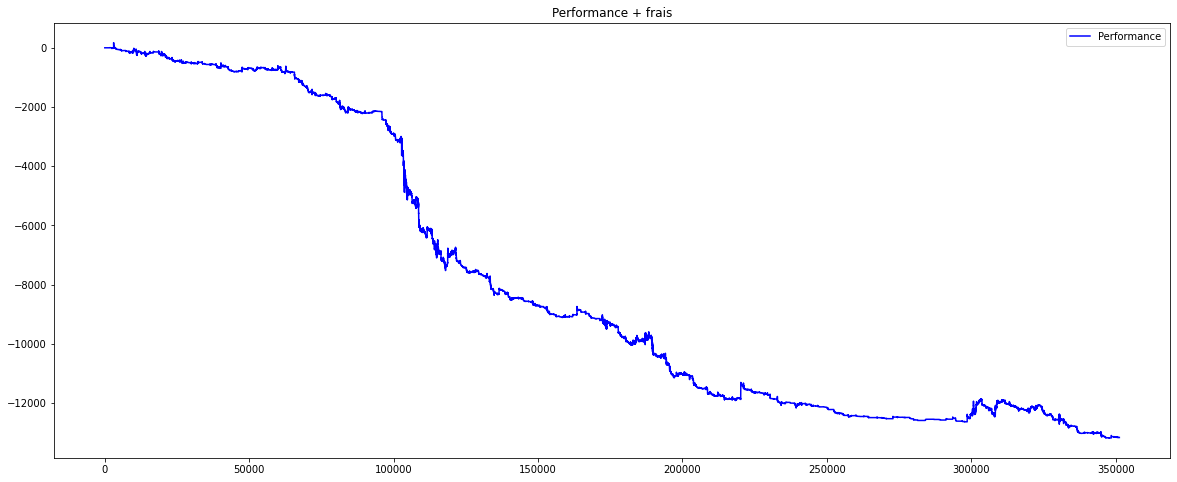

In [92]:
plt.figure(figsize=(20,8))

compte=[0]

Seuil_hausse_model, Seuil_baisse_model = seuil_(y_predected_model, 0.05) # Etablissement des seuil d'achat et de vente

for i in range(len(y_predected_model)-1):
  if(y_predected_model[i]>Seuil_hausse_model):
    compte+=[compte[-1]+y_test_return[i]-0.90]
  else:
    compte+=[compte[-1]]

plt.plot(compte, label='Performance', color='blue')

plt.title("Performance + frais")

plt.legend()

plt.show()

On se retrouve donc très perdant et cela est normal. Pour pallier à cela on peut simplement prédire le cours sur une échelle de temps supérieur à 1 minute de sorte à ce que les frais deviennent négligeable ou travailler dans une banque pour avoir des frais super faible :)